# A Simple Netflix Movie and TVshow recommandation system using Weaviate 

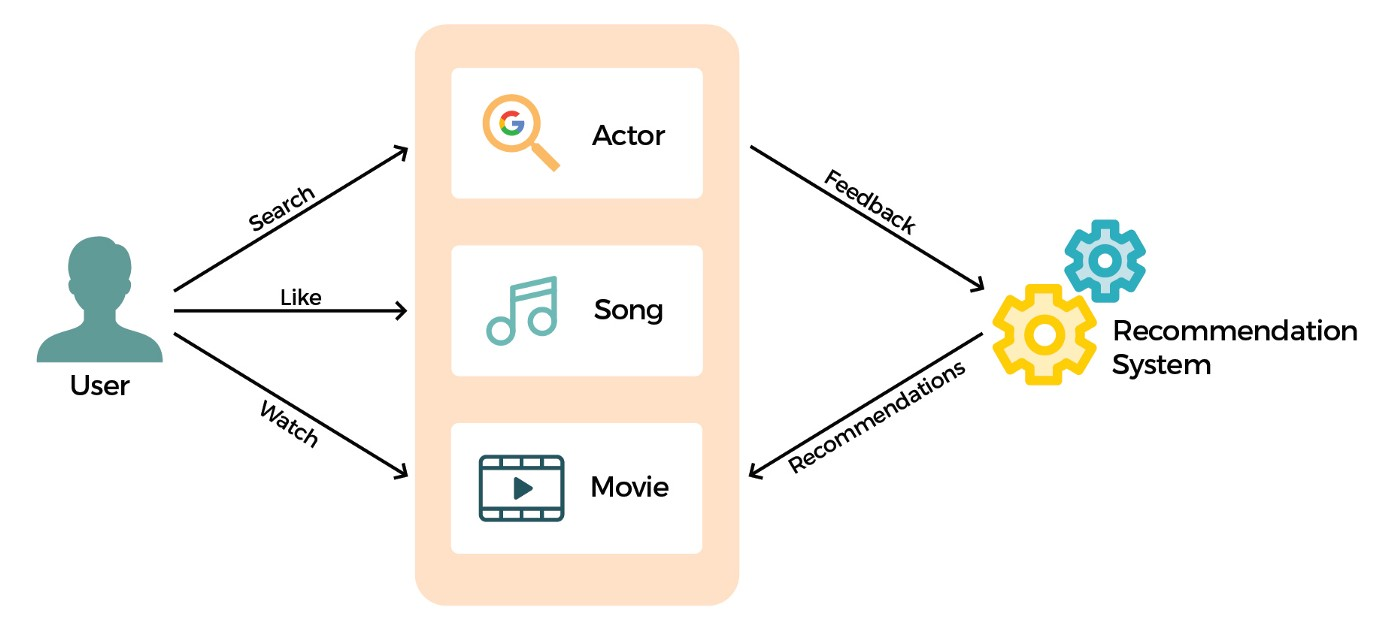

The diagram given above shows the system architecture of a Recommendation system.
The recommendation system generally is of 3 types, Which are shown below




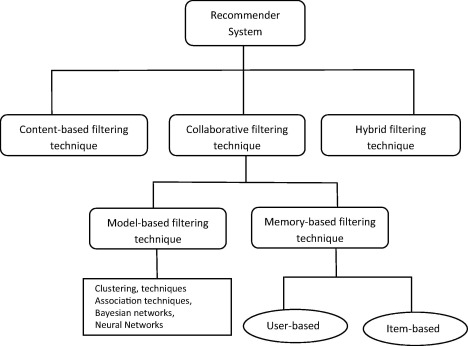




For more information you can check [**this**](https://thingsolver.com/introduction-to-recommender-systems/)

In this example we will create a recommendation system based on content-based filtering technique. For that purpose, We will use __Weaviate__ to vectorize and store data, and to find answers to natural language queries. 

**Weaviate in detail**: Weaviate is a low-latency vector search engine with out-of-the-box support for different media types (text, images, etc.). It offers Semantic Search, Question-Answer Extraction, Classification, Customizable Models (PyTorch/TensorFlow/Keras), and more. Built from scratch in Go, Weaviate stores both objects and vectors, allowing for combining vector search with structured filtering and the fault-tolerance of a cloud-native database, all accessible through GraphQL, REST, and various programming language clients.

You can check Weaviate's official documentation over [**here**](https://weaviate.io/developers/weaviate/current/)

# Prerequisites

* __Create an weaviate instance/cluster.__

Creating a Weaviate instance can be done in multiple ways. It can be done using a docker-compose.yaml file that can be    generated [here](https://weaviate.io/developers/weaviate/current/getting-started/installation.html#customize-your-weaviate-setup). For this option you have to have **docker** and **docker-compose installed**, and space on your drive.

Another option is to create an account on [Weaviate Cloud Service](https://console.semi.technology/)(WCS) and create a cluster there. There are different options for clusters you can choose from. If you do not have an account go ahead and create one.

#  Let's begin

The first thing we have to do now, is to install the Weaviate Python Client. It can be done using pip command in the terminal

pip install weaviate-client==3.0.0

In [1]:
import weaviate 

Import weaviate to communicate to the Weaviate instance

In [2]:
client = weaviate.Client("http://localhost:8080")

Connect to the cluster.

In [3]:
client.is_ready()

True

To check the status of a cluster we can use **is_ready** method as shown above

In [4]:
import pandas as pd
df = pd.read_csv('netflix_titles.csv')
import warnings
warnings.filterwarnings('ignore')

For this example, we are using a dataset from [**kaggle**](https://www.kaggle.com/).

**About this Dataset:** Netflix is one of the most popular media and video streaming platforms. They have over 8000 movies or tv shows available on their platform, as of mid-2021, they have over 200M Subscribers globally. This tabular dataset consists of listings of all the movies and tv shows available on Netflix, along with details such as - cast, directors, ratings, release year, duration, etc.

You can find the dataset [here](https://www.kaggle.com/datasets/shivamb/netflix-shows)

# Preprocessing 

In [5]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


As you can see the dataset has two types of content, **Movies and TV Shows**

So first of all, we will split the dataframe into two dataframes using simple commands of pandas library.

In [6]:
df1 = df[df['type']=='Movie']

In [7]:
df2 = df[df['type']=='TV Show']

In [8]:
df1.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90,Documentaries,"As her father nears the end of his life, filmm..."
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104,"Comedies, Dramas",A woman adjusting to life after a loss contend...
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127,"Dramas, International Movies",After most of her family is murdered in a terr...


In [9]:
df2.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,"September 24, 2021",2021,TV-MA,1,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...


In [10]:
df1.reset_index(inplace=True)
df2.reset_index(inplace=True)
df1.drop('index',axis='columns', inplace=True)
df2.drop('index',axis='columns', inplace=True)

As we have splited the data, we don't need the column of 'type' and 'show_id'.

So we will drop these two columns using drop function of pandas

In [11]:
df1.drop('type',
  axis='columns', inplace=True)

In [12]:
df2.drop('type',
  axis='columns', inplace=True)

In [13]:
df1.drop('show_id',
  axis='columns', inplace=True)

In [14]:
df2.drop('show_id',
  axis='columns', inplace=True)

There are some of missing values in our dataframe, we will need to fill them.

In [15]:
df1.fillna("Not Given",inplace=True)

In [16]:
df2.fillna("Not Given",inplace=True)

Our dataframes are ready

# Creating schema with appropriate data types

So lets create the Movie class and TvShow class. We know that the Movie has a title, director, cast, country, Listed_In and description and same for TvShow

More about schemas and how to create them can be found [here](https://weaviate.io/developers/weaviate/current/data-schema/schema-configuration.html) and [here](https://weaviate.io/developers/weaviate/current/restful-api-references/schema.html#parameters).

In [17]:
client.schema.delete_all()
schema = {
    "classes": [
        {
            "class": "Movie",
            "description": "A Netflix movie",
            "properties": [
                {
                    "name": "title",
                    "description": "The name of the movie",
                    "dataType": ["string"]
                }, {
                    "name": "director",
                    "description": "The name of the director of the movie",
                    "dataType": ["text[]"]
                }, {
                    "name": "cast",
                    "description": "Cast of the movie",
                    "dataType": ["text[]"]
                }, {
                    "name": "country",
                    "description": "The country/countries in which movie was created",
                    "dataType": ["text[]"]
                },{
                    "name": "listedin",
                    "description": "The movie was listed in",
                    "dataType": ["text[]"]
                },{
                    "name": "description",
                    "description": "The summary",
                    "dataType": ["text"]
                }
                
            ]
      
        },        {
            "class": "TvShow",
            "description": "A Netflix TV Show",
            "properties": [
                {
                    "name": "title",
                    "description": "The name of the Tv show",
                    "dataType": ["string"]
                }, {
                    "name": "director",
                    "description": "The name of the director of the TV show",
                    "dataType": ["text[]"]
                }, {
                    "name": "cast",
                    "description": "Cast of the TV Show",
                    "dataType": ["text[]"]
                }, {
                    "name": "country",
                    "description": "The country/countries in which TV show was created",
                    "dataType": ["text[]"]
                },{
                    "name": "listedin",
                    "description": "The TV show was listed in",
                    "dataType": ["text[]"]
                },{
                    "name": "description",
                    "description": "The summary",
                    "dataType": ["text"]
                }
                
            ]
      
        }
    ]
}

client.schema.create(schema)

In the schema above we create a class named **Movie** and **TvShow** with the description.The description is there to explain the user what this class is about.

Also we define 6 properties for each class : title - The title of the movie/tvshow, of type string (case sensitive), director, cast, country and listedin, of data type text[] and description, of data type text (case insensitive). The list of primitive data types can be found [here](https://weaviate.io/developers/weaviate/current/data-schema/datatypes.html).

**NOTE 1**: The properties should always be in cameCase format and starts with a lowercased word.

**NOTE 2**: The property data type is always a list because it can accept more than one data type.

Our schema is ready.This way we can save now the schema in a file and in the next session just directly import it by providing the file path. 

In [18]:
import json
# save schema to file
with open('schema.json', 'w') as outfile: 
    json.dump(schema, outfile)
# remove current schema from Weaviate, removes all the data too
client.schema.delete_all()
# import schema using file path
client.schema.create('schema.json')

#  Load data

In [19]:
import uuid
def generate_uuid(class_name: str, identifier: str,
                  test: str = 'teststrong') -> str:
    """ Generate a uuid based on an identifier
    :param identifier: characters used to generate the uuid
    :type identifier: str, required
    :param class_name: classname of the object to create a uuid for
    :type class_name: str, required
    """
    test = 'overwritten'
    return str(uuid.uuid5(uuid.NAMESPACE_DNS, class_name + identifier))

The above function will generate a uuid based on an identifier

In [20]:
import datetime
def log(i: str) -> str:
    """ A simple logger
    :param i: the log message
    :type i: str
    """
    now = datetime.datetime.utcnow()
    print(now, "| " + str(i))

The above function is a simple logger

Now that we have our data ready, and Weaviate is aware of what kind of data we have, we can add the **Movies** and **TvShows** to the Weaviate instance.

In [21]:
def add_movies(data, batch_size=512, debug_mode=False): 
    no_items_in_batch = 0

    for index, row in data.iterrows():
        res_object = { 
            "title": row["title"] + '.' ,
            "director": row["director"],
            "cast": row["cast"],
            "country": row["country"],
            "listedin": row["listed_in"],
            "description": row["description"]
        }
        res_object['cast'] = res_object['cast'].split(", ")
        res_object['country'] = res_object['country'].split(", ")
        res_object['director'] = res_object['director'].split(", ")
        res_object['listedin'] = res_object['listedin'].split(", ")

        res_uuid = generate_uuid('Movie', str(row["title"])+str(row["director"])+str(row['cast'])+str(row['country'])+str(row['listed_in'])+str(row['description']))

        client.batch.add_data_object(res_object, "Movie", res_uuid)
        no_items_in_batch += 1

        if no_items_in_batch >= batch_size:
            results = client.batch.create_objects()
            
            if debug_mode:
                for result in results:
                    if result['result'] != {}:
                        log(result['result'])

                message = str(index) + ' / ' + str(data.shape[0]) +  ' items imported'
                log(message)

            no_items_in_batch = 0

    client.batch.create_objects()

The above function will take **data,batch_size,debug_mode** as input parameters.

Adding data will be done by adding object by object iteratively. This can be done using the **data_object** object attribute of the client.

And when the number of items in a batch becomes greater than equal to the batch_size given by the user, the items will be imported to weaviate using **create_objects** attribute of the client 

In [22]:
add_movies(df1,500,True)

2022-04-05 04:19:40.247868 | 499 / 6131 items imported
2022-04-05 04:19:40.919011 | 999 / 6131 items imported
2022-04-05 04:19:41.452863 | 1499 / 6131 items imported
2022-04-05 04:19:41.958898 | 1999 / 6131 items imported
2022-04-05 04:19:42.451333 | 2499 / 6131 items imported
2022-04-05 04:19:42.880628 | 2999 / 6131 items imported
2022-04-05 04:19:43.316085 | 3499 / 6131 items imported
2022-04-05 04:19:43.865479 | 3999 / 6131 items imported
2022-04-05 04:19:44.630706 | 4499 / 6131 items imported
2022-04-05 04:19:45.265244 | 4999 / 6131 items imported
2022-04-05 04:19:45.884036 | 5499 / 6131 items imported
2022-04-05 04:19:46.532124 | 5999 / 6131 items imported


Calling the **add_movies** function

In [23]:
def add_tvshow(data, batch_size=512, debug_mode=False): 
    no_items_in_batch = 0

    for index, row in data.iterrows():
        res_object = { 
            "title": row["title"] + '.' ,
            "director": row["director"],
            "cast": row["cast"],
            "country": row["country"],
            "listedin": row["listed_in"],
            "description": row["description"]
        }
        res_object['cast'] = res_object['cast'].split(", ")
        res_object['country'] = res_object['country'].split(", ")
        res_object['director'] = res_object['director'].split(", ")
        res_object['listedin'] = res_object['listedin'].split(", ")
         
        res_uuid = generate_uuid('TvShow', str(row["title"])+str(row["director"])+str(row['cast'])+str(row['country'])+str(row['listed_in'])+str(row['duration'])+str(row['description']))

        client.batch.add_data_object(res_object, "TvShow", res_uuid)
        no_items_in_batch += 1

        if no_items_in_batch >= batch_size:
            results = client.batch.create_objects()
            
            if debug_mode:
                for result in results:
                    if result['result'] != {}:
                        log(result['result'])

                message = str(index) + ' / ' + str(data.shape[0]) +  ' items imported'
                log(message)

            no_items_in_batch = 0

    client.batch.create_objects()

In [24]:
add_tvshow(df2,500,True)

2022-04-05 04:19:47.439626 | 499 / 2676 items imported
2022-04-05 04:19:48.045393 | 999 / 2676 items imported
2022-04-05 04:19:48.635017 | 1499 / 2676 items imported
2022-04-05 04:19:49.228900 | 1999 / 2676 items imported
2022-04-05 04:19:49.897980 | 2499 / 2676 items imported


Repeat the process for TvShow class

To see the full capabilities of this new **Batch** object see the full documentation [here](https://weaviate-python-client.readthedocs.io/en/latest/weaviate.batch.html#weaviate.batch.Batch) or execute the help function on Batch or/and any Batch methods, like this: help(Batch)

# Query data.

Now we have the data imported and ready to be queried. Data can be queried by using the **query** attribute of the client object **(client.query)**.

The data is queried using GraphQL syntax, and can be done in three different ways:

- **GET**: query that gets objects and from Weaviate. More information [here](https://weaviate.io/developers/weaviate/current/graphql-references/get.html)

  Use **client.query.get(class_name, properties).OTHER_OPTIONAL_FILTERS.do()**
  

- **AGGREGATE**: query that aggregates data. More information [here](https://weaviate.io/developers/weaviate/current/graphql-references/aggregate.html)

  Use **client.query.aggregate(class_name, properties).OTHER_OPTIONAL_FILTERS.do()**
  

Or use a GraphQL query represented as a str.
Use **client.query.raw()**

NOTE: Both **.get** and **.aggregate** require the call of the **.do()** method to run the query. .raw() does NOT.

In [25]:
nearText = {
  "concepts": ["dicaprio"]
}

In [26]:
result = client.query.get(class_name='Movie', properties=["title"])\
    .with_limit(5)\
    .with_near_text(nearText)\
    .do()

In [27]:
result

{'data': {'Get': {'Movie': [{'title': 'Gangs of New York.'},
    {'title': "What's Eating Gilbert Grape."},
    {'title': "Lee Daniels' The Butler."},
    {'title': 'Shutter Island.'},
    {'title': 'The Irishman: In Conversation.'}]}}}

We can do much more by stacking multiple methods. The available methods for .get are:

- **.with_limit** - set another limit of returned objects.

- **.with_near_object** - get objects that are similar to the object passed to this method.

- **.with_near_text** - get objects that are similar to the text passed to this method.

- **.with_near_vector** - get objects that are similar to the vector passed to this method.

- **.with_where** - get objects that are filtered using the Where filter, see this [link](https://weaviate.io/developers/weaviate/current/graphql-references/filters.html#where-filter) for examples and explanation.

- Also instead of .do() one can use the .build() method that returns the GraphQL query as a string. This string can be passed to .raw() method.

NOTE: Only one .with_near_* can be used per query.

In [28]:
nearText2 = {
  "concepts": ["comedy"]
}

In [29]:
result2 = client.query.get(class_name='Movie', properties=["title","listedin"])\
    .with_limit(5)\
    .with_near_text(nearText2)\
    .do()

In [30]:
result2

{'data': {'Get': {'Movie': [{'listedin': ['Stand-Up Comedy'],
     'title': 'D.L. Hughley: Clear.'},
    {'listedin': ['Music & Musicals', 'Stand-Up Comedy'],
     'title': 'Reggie Watts: Spatial.'},
    {'listedin': ['Comedies', 'Documentaries'],
     'title': 'Monty Python: Before the Flying Circus.'},
    {'listedin': ['Stand-Up Comedy'], 'title': 'ADAM SANDLER 100% FRESH.'},
    {'listedin': ['Stand-Up Comedy'],
     'title': 'The Original Kings of Comedy.'}]}}}

In [31]:
result3 = client.query.get(class_name='TvShow', properties=["title","listedin"])\
    .with_limit(5)\
    .with_near_text(nearText2)\
    .do()

In [32]:
result3

{'data': {'Get': {'TvShow': [{'listedin': ['Stand-Up Comedy & Talk Shows',
      'TV Comedies'],
     'title': 'The Standups.'},
    {'listedin': ['Stand-Up Comedy & Talk Shows', 'TV Comedies'],
     'title': 'Comedians in Cars Getting Coffee.'},
    {'listedin': ['Stand-Up Comedy & Talk Shows', 'TV Comedies'],
     'title': 'The Degenerates.'},
    {'listedin': ['Stand-Up Comedy & Talk Shows', 'TV Comedies'],
     'title': 'Dave Chappelle.'},
    {'listedin': ['International TV Shows', 'TV Comedies'],
     'title': 'Comedy Premium League.'}]}}}

### Of course when it comes to querying data, the possibilities are endless. Have fun experimenting with these capabilities.

Feel free to check out and contribute to weaviate-client on [GitHub](https://github.com/semi-technologies/weaviate-python-client).

And I have also created a webpage in which we put a concept of movie and it returns top most recommended movies. Basically a simpler version for querying

Do check its code and working video which is there in the repository